In [1]:
load(file = "..//gene_length.rds")

In [2]:
head(gene_lengths)
dim(gene_lengths)

,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<int>
ENSMUSG00000102693.2,ENSMUSG00000102693.2,4933401J01Rik,chr1,3143476,3144545,TEC,+,1070
ENSMUSG00000064842.3,ENSMUSG00000064842.3,Gm26206,chr1,3172239,3172348,snRNA,+,110
ENSMUSG00000051951.6,ENSMUSG00000051951.6,Xkr4,chr1,3276124,3741721,protein_coding,-,465598
ENSMUSG00000102851.2,ENSMUSG00000102851.2,Gm18956,chr1,3322980,3323459,processed_pseudogene,+,480
ENSMUSG00000103377.2,ENSMUSG00000103377.2,Gm37180,chr1,3435954,3438772,TEC,-,2819
ENSMUSG00000104017.2,ENSMUSG00000104017.2,Gm37363,chr1,3445779,3448011,TEC,-,2233


[1] 55322     8

In [3]:
gene_lengths_protein_coding <- gene_lengths[gene_lengths$Class=="protein_coding",]
head(gene_lengths_protein_coding)

,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<int>
ENSMUSG00000051951.6,ENSMUSG00000051951.6,Xkr4,chr1,3276124,3741721,protein_coding,-,465598
ENSMUSG00000025900.14,ENSMUSG00000025900.14,Rp1,chr1,4069780,4479464,protein_coding,-,409685
ENSMUSG00000025902.14,ENSMUSG00000025902.14,Sox17,chr1,4561154,4567577,protein_coding,-,6424
ENSMUSG00000033845.14,ENSMUSG00000033845.14,Mrpl15,chr1,4843429,4855962,protein_coding,-,12534
ENSMUSG00000025903.15,ENSMUSG00000025903.15,Lypla1,chr1,4878011,4918633,protein_coding,+,40623
ENSMUSG00000104217.2,ENSMUSG00000104217.2,Gm37988,chr1,4878115,4956993,protein_coding,+,78879


## Make file for 5' UTR length of each ENST

In [4]:
suppressMessages(suppressWarnings(library(GenomicFeatures)))
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library('rtracklayer')))

# 5' UTR length
ensemble_gtf <- makeTxDbFromGFF('Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz', organism = "Homo sapiens")
fiveUTRs          <- fiveUTRsByTranscript(ensemble_gtf,use.names=TRUE)
length_fiveUTRs   <- width(ranges(fiveUTRs))
the_lengths        <- as.data.frame(length_fiveUTRs)
the_lengths        <- the_lengths %>% group_by(group, group_name) %>% summarise(sum(value))
the_lengths        <- unique(the_lengths[,c("group_name", "sum(value)")])
colnames(the_lengths) <- c("ENST", "5' UTR Length")
the_lengths <- as.data.frame(the_lengths)

# Read GTF and make ENSG and ENST information for each genes
GTF="Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz"
GTF <- import(GTF)
GRCm39.104.gtf <- as.data.frame(GTF)

GRCm39.104.selected <- GRCm39.104.gtf %>%
  filter(type=="gene") %>%
  rename(Chr=seqnames, Type=type,ENSG=gene_id, Symbol=gene_name, GeneType=gene_biotype, GeneLength=width) %>%
  select(Chr, Type, GeneType, ENSG, Symbol, GeneLength) 

GRCm39.104.ENST <- GRCm39.104.gtf %>%
  rename(ENSG=gene_id, ENST=transcript_id, Symbol=gene_name) %>%
  select(ENSG, ENST, Symbol) %>%
  tidyr::drop_na()%>%  #filter(!is.na(ENST)) ##Both filter/is.na will work
  distinct()

# Make final file
UTR_Length <- merge(GRCm39.104.ENST, the_lengths, by ="ENST")
head(UTR_Length)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.



,ENST,ENSG,Symbol,5' UTR Length
,<chr>,<chr>,<chr>,<int>
1,ENSMUST00000000001,ENSMUSG00000000001,Gnai3,141
2,ENSMUST00000000003,ENSMUSG00000000003,Pbsn,140
3,ENSMUST00000000010,ENSMUSG00000020875,Hoxb9,85
4,ENSMUST00000000028,ENSMUSG00000000028,Cdc45,313
5,ENSMUST00000000033,ENSMUSG00000048583,Igf2,115
6,ENSMUST00000000049,ENSMUSG00000000049,Apoh,51


## Load functions

In [5]:
suppressMessages(suppressWarnings(source("./jupyter_common.R")))
#load('./rdata/jupyter_common.rdata')
load('./rdata/riboprof_170224.rdna_rn18s_161021.rdna_rn18s_limma-voom.mrna.rdata')

## Common parameters

In [6]:
version_gtf <- "v104"
species <- "mmusculus"
platform <- "rnaseq"
#platform <- "riboseq"

## RNAseq

In [7]:
condstr <- "rnaseq.protein_coding_gene"

## unt vs. tgfb vs. cx5461

### rev-Up-Down

In [8]:
sym_mrna_up_dn <- setdiff(sym_mrna_up_cx_dn, sym_ribo_up_cx_dn)

### check

In [9]:
f <- grepl("Rp", sym_mrna_up_dn)
sym_mrna_up_cx_dn[f]

character(0)

In [10]:
f <- grepl("Rp", sym_mrna_up)
sym_mrna_up[f]
f <- grepl("Rp", sym_mrna2_dn)
sym_mrna2_dn[f]

[1] "Rpl22l1" "Rpp38"   "Rps6ka2" "Rps6kb2" "Rps6kc1"

[1] "Rpp14"  "Rprd1b"

### 5' UTR

In [11]:
df <- UTR_Length
idx <- match(sym_mrna_up_dn, df$Symbol)
f <- !is.na(idx); idx <- idx[f]
df_updn_5utr <- data.frame(sym=df[idx,"Symbol"], len=df[idx,"5' UTR Length"], type="Up-Down")
df_updn_5utr <- df_updn_5utr[order(df_updn_5utr$len), ]

head(df_updn_5utr)
dim(df_updn_5utr)

,sym,len,type
,<chr>,<int>,<chr>
107,Zfp469,2,Up-Down
1,0610010F05Rik,5,Up-Down
18,Crybg3,5,Up-Down
21,Ctsw,24,Up-Down
43,Ktn1,31,Up-Down
46,Lix1l,33,Up-Down


[1] 107   3

In [12]:
f <- grepl("Zeb", df_updn_5utr$sym)
df_updn_5utr[f,]

sym,len,type
<chr>,<int>,<chr>


In [13]:
idx <- which(df_updn_5utr$len == 0)
sym_no_5utr <- df_updn_5utr[idx, "sym"]
sym_no_5utr
length(sym_no_5utr)

character(0)

[1] 0

### rev-DownUP

In [14]:
sym_mrna_dn_up <- setdiff(sym_mrna_dn_cx_up, sym_ribo_dn_cx_up)

In [15]:
f <- grepl("Rp", sym_mrna_dn_cx_up)
sym_mrna_dn_cx_up[f]

character(0)

In [16]:
f <- grepl("Rp", sym_mrna_dn)
sym_mrna_dn[f]
f <- grepl("Rp", sym_mrna2_up)
sym_mrna2_up[f]

[1] "Rp9"        "Rpa1"       "Rpa2"       "Rpa3"       "Rpap1"     
 [6] "Rpap3"      "Rpe"        "Rpf2"       "Rpl13"      "Rpl13a"    
[11] "Rpl14"      "Rpl15"      "Rpl18"      "Rpl18a"     "Rpl19-ps11"
[16] "Rpl21"      "Rpl22"      "Rpl29"      "Rpl32"      "Rpl36"     
[21] "Rpl36al"    "Rpl37"      "Rpl37a"     "Rpl37rt"    "Rpl4"      
[26] "Rpl41"      "Rpl6"       "Rpl7a"      "Rpl8"       "Rpl9"      
[31] "Rpp25l"     "Rpp30"      "Rpph1"      "Rps10"      "Rps11"     
[36] "Rps15"      "Rps2"       "Rps2-ps10"  "Rps2-ps6"   "Rps21"     
[41] "Rps25"      "Rps26"      "Rps27"      "Rps28"      "Rps29"     
[46] "Rps3a1"     "Rps3a2"     "Rps3a3"     "Rps4x"      "Rps6"      
[51] "Rps6ka1"    "Rps6ka5"    "Rps8"       "Rpsa"

[1] "Rps27l"

### 5' UTR

In [17]:
df <- UTR_Length

idx <- match(sym_mrna_dn_up, df$Symbol)
f <- !is.na(idx); idx <- idx[f]
df_dnup_5utr <- data.frame(sym=df[idx,"Symbol"], len=df[idx,"5' UTR Length"], type="Down-Up")
df_dnup_5utr <- df_dnup_5utr[order(df_dnup_5utr$len), ]

head(df_dnup_5utr)
dim(df_dnup_5utr)

,sym,len,type
,<chr>,<int>,<chr>
30,Eme2,6,Down-Up
57,Lgals9,15,Down-Up
102,Stxbp2,15,Down-Up
2,9530053A07Rik,19,Down-Up
47,H2bc4,33,Down-Up
74,Pex6,37,Down-Up


[1] 116   3

In [18]:
f <- grepl("Rp", df_dnup_5utr$sym)
df_dnup_5utr[f,]

sym,len,type
<chr>,<int>,<chr>


In [19]:
idx <- which(df_dnup_5utr$len == 0)
sym_no_5utr <- df_dnup_5utr[idx, "sym"]
sym_no_5utr
length(sym_no_5utr)

character(0)

[1] 0

## Violin plot

### 5' UTR

In [20]:
head(df_updn_5utr)
quantile_updn_5utr <- quantile(df_updn_5utr$len, probs = c(0.25,0.5,0.75))
quantile_updn_5utr

,sym,len,type
,<chr>,<int>,<chr>
107,Zfp469,2,Up-Down
1,0610010F05Rik,5,Up-Down
18,Crybg3,5,Up-Down
21,Ctsw,24,Up-Down
43,Ktn1,31,Up-Down
46,Lix1l,33,Up-Down


25%   50%   75% 
122.0 207.0 345.5

In [21]:
head(df_dnup_5utr)
quantile_dnup_5utr <- quantile(df_dnup_5utr$len, probs = c(0.25,0.5,0.75))
quantile_dnup_5utr

,sym,len,type
,<chr>,<int>,<chr>
30,Eme2,6,Down-Up
57,Lgals9,15,Down-Up
102,Stxbp2,15,Down-Up
2,9530053A07Rik,19,Down-Up
47,H2bc4,33,Down-Up
74,Pex6,37,Down-Up


25%   50%   75% 
 91.0 176.5 288.0

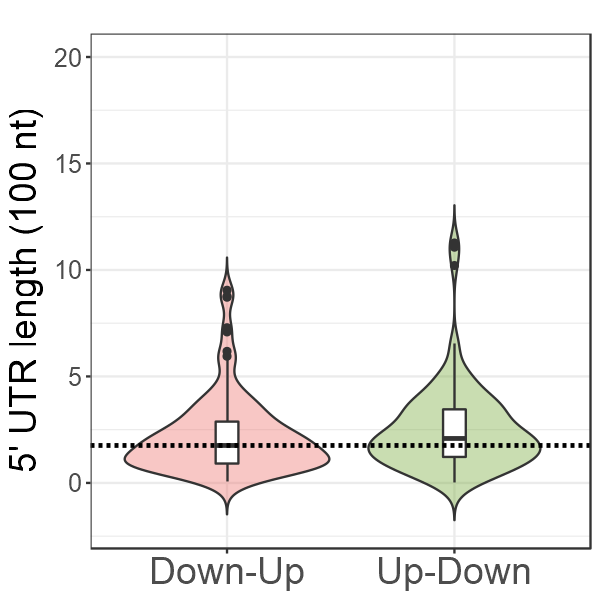

In [22]:
df_5utr <- rbind(df_dnup_5utr, df_updn_5utr)

yscale_100 <- function(x) {
  sprintf("%.0f", x/100)
}

gg <- ggplot(df_5utr, aes(x=type, y=len, fill=type)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white") + theme_bw() +
  theme(legend.position = "none") + 
  xlab(NULL) + 
  #ylab(expression("5' UTR"~log[2](length)~(nt))) + 
  ylab(expression("5' UTR length (100 nt)")) + 
  ggtitle('') +
  theme(plot.title=element_text(size=10),
      axis.text.x=element_text(size=22),
      axis.text.y=element_text(size=15, lineheight=0.9),
      axis.title.x=element_text(size=9),
      axis.title.y=element_text(size=22)) +
  scale_y_continuous(label=yscale_100, limit=c(-200,2000)) +
  geom_hline(yintercept=c(quantile_dnup_5utr[["50%"]]),
             linetype="dashed", size=1, color = "black") +
  scale_fill_manual(values = 
      alpha(c('no'='#aaaaaa','Up-Down'='#7aaa3d', 'Down-Up'='#ed7470'), 0.4))


print_figure(gg, width=5, height=5,
    file=sprintf("violin_plot.%s.reversible.5utr_length", condstr))


## Ribo-seq

In [23]:
condstr <- "riboseq.protein_coding_gene"

### unt48 vs. tgfb48 vs. cx5461

### rev-upDown

In [24]:
sym_ribo_up_dn <- setdiff(sym_ribo_up_cx_dn, sym_mrna_up_cx_dn)

In [25]:
f <- grepl("Zeb", sym_ribo_up_dn)
sym_ribo_up_cx_dn[f]

[1] "Usp22"

### 5' UTR

In [26]:
df <- UTR_Length

idx <- match(sym_ribo_up_dn, df$Symbol)
f <- !is.na(idx); idx <- idx[f]
df_updn_5utr <- data.frame(sym=df[idx,"Symbol"], len=df[idx,"5' UTR Length"], type="Up-Down")
df_updn_5utr <- df_updn_5utr[order(df_updn_5utr$len), ]

head(df_updn_5utr)
dim(df_updn_5utr)

,sym,len,type
,<chr>,<int>,<chr>
3,Acot7,4,Up-Down
47,Chd3,15,Up-Down
280,Zswim6,15,Up-Down
140,Lrrfip1,19,Up-Down
101,Glg1,20,Up-Down
83,Fanca,23,Up-Down


[1] 280   3

In [27]:
f <- grepl("Zeb", df_updn_5utr$sym)
df_updn_5utr[f,]

,sym,len,type
,<chr>,<int>,<chr>
275,Zeb1,46,Up-Down


In [28]:
idx <- which(df_updn_5utr$len == 0)
sym_no_5utr <- df_updn_5utr[idx, "sym"]
sym_no_5utr
length(sym_no_5utr)

character(0)

[1] 0

### rev-downUp

In [29]:
sym_ribo_dn_up <- setdiff(sym_ribo_dn_cx_up, sym_mrna_dn_cx_up)

### 5' UTR

In [30]:
df <- UTR_Length

idx <- match(sym_ribo_dn_up, df$Symbol)
f <- !is.na(idx); idx <- idx[f]
df_dnup_5utr <- data.frame(sym=df[idx,"Symbol"], len=df[idx,"5' UTR Length"], type="Down-Up")
df_dnup_5utr <- df_dnup_5utr[order(df_dnup_5utr$len), ]

head(df_dnup_5utr)
dim(df_dnup_5utr)

,sym,len,type
,<chr>,<int>,<chr>
84,H4c6,5,Down-Up
120,Naxe,5,Down-Up
79,H2bc7,6,Down-Up
82,H4c14,7,Down-Up
62,Fam162a,12,Down-Up
38,Copz1,14,Down-Up


[1] 243   3

In [31]:
f <- grepl("Rp", df_dnup_5utr$sym)
df_dnup_5utr[f,]

,sym,len,type
,<chr>,<int>,<chr>
168,Rpl22,31,Down-Up
178,Rpl37a,31,Down-Up
191,Rps19,32,Down-Up
176,Rpl36,35,Down-Up
197,Rps27,36,Down-Up
177,Rpl37,37,Down-Up
183,Rps10,37,Down-Up
192,Rps19bp1,37,Down-Up
163,Rpl11,40,Down-Up


In [32]:
idx <- which(df_dnup_5utr$len == 0)
sym_no_5utr <- df_dnup_5utr[idx, "sym"]
sym_no_5utr
length(sym_no_5utr)

character(0)

[1] 0

## Violin plot

### 5' UTR

In [33]:
head(df_updn_5utr)
quantile_updn_5utr <- quantile(df_updn_5utr$len, probs = c(0.25,0.5,0.75))
quantile_updn_5utr

,sym,len,type
,<chr>,<int>,<chr>
3,Acot7,4,Up-Down
47,Chd3,15,Up-Down
280,Zswim6,15,Up-Down
140,Lrrfip1,19,Up-Down
101,Glg1,20,Up-Down
83,Fanca,23,Up-Down


25%    50%    75% 
119.00 202.50 313.25

In [34]:
head(df_dnup_5utr)
quantile_dnup_5utr <- quantile(df_dnup_5utr$len, probs = c(0.25,0.5,0.75))
quantile_dnup_5utr

,sym,len,type
,<chr>,<int>,<chr>
84,H4c6,5,Down-Up
120,Naxe,5,Down-Up
79,H2bc7,6,Down-Up
82,H4c14,7,Down-Up
62,Fam162a,12,Down-Up
38,Copz1,14,Down-Up


25%   50%   75% 
 58.0 104.0 175.5

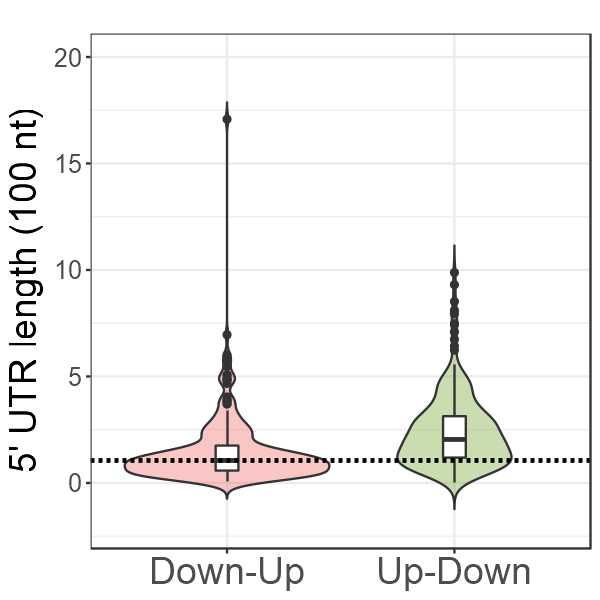

In [35]:
df_5utr <- rbind(df_dnup_5utr, df_updn_5utr)

yscale_100 <- function(x) {
  sprintf("%.0f", x/100)
}

gg <- ggplot(df_5utr, aes(x=type, y=len, fill=type)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white") + theme_bw() +
  theme(legend.position = "none") + 
  xlab(NULL) + 
  #ylab(expression("5' UTR"~log[2](length)~(nt))) + 
  ylab(expression("5' UTR length (100 nt)")) + 
  ggtitle('') +
  theme(plot.title=element_text(size=10),
      axis.text.x=element_text(size=22),
      axis.text.y=element_text(size=15, lineheight=0.9),
      axis.title.x=element_text(size=9),
      axis.title.y=element_text(size=22)) +
  scale_y_continuous(label=yscale_100, limit=c(-200,2000)) +
  geom_hline(yintercept=c(quantile_dnup_5utr[["50%"]]),
             linetype="dashed", size=1, color = "black") +
  scale_fill_manual(values = 
      alpha(c('no'='#aaaaaa','Up-Down'='#7aaa3d', 'Down-Up'='#ed7470'), 0.4))


print_figure(gg, width=5, height=5,
    file=sprintf("violin_plot.%s.reversible.5utr_length", condstr))